In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification and in Ad-hoc IR
## 4. Document Representations

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)
- Latent Semantic Indexing (LSI)

We consider four term weighting schemes:

- Binary
- Bag of Words (BOW)
- TF-IDF
- Okapi BM25

And we consider two similarities:

- Inner Product (IP)
- Relaxed Word Mover's Distance (RWMD)

## 6. Evaluation

Not all combinations of document representations, term weighting schemes, and similarities are evaluated:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | Soft VSM IP | LSI IP |
|--|--|--|--|--|
| Binary | ❌ | ❌ | ✅<sup>2</sup>  | ❌ |
| BOW | ✅ | ✅ | ✅<sup>1, 2</sup> | ❌ |
| TF-IDF | ✅ | ❌ | ✅ | ✅ |
| Okapi BM25 | ✅ | ❌ | ❌ | ❌ |

<sup>1</sup> We use non-normalized BOW queries, $L_1$-normalized BOW collection documents, and $L_1$-normalized inner product.  
<sup>2</sup> We only use the dense soft VSM. 

In [2]:
configurations = [
    # ('random', 'random', 'random', 'random'),
    ('vsm', 'bow', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1),
    ('vsm', 'bm25', 'inner_product', 32),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32),
    ('lsi', 'tfidf', 'inner_product', 32),
    # ('vsm', 'tfidf', 'inner_product', 32),
    # ('dense_soft_vsm', 'binary', 'inner_product', 32),
    # ('dense_soft_vsm', 'binary', 'inner_product', 1),
    # ('dense_soft_vsm', 'bow', 'inner_product', 32),
    # ('dense_soft_vsm', 'bow', 'inner_product', 1),
    # ('vsm', 'bow', 'wmd', 1),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1),
    ('vsm', 'bow', 'wmd', 32),
]
configuration_names = {
    ('random', 'random', 'random', 'random'): 'Random',
    ('vsm', 'bow', 'inner_product', 32): 'BoW',
    ('vsm', 'tfidf', 'inner_product', 32): 'TF-IDF',
    ('vsm', 'bm25', 'inner_product', 32): 'Okapi BM25',
    ('lsi', 'tfidf', 'inner_product', 32): 'LSI',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32): 'Dense SCM (32b)',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1): 'Dense SCM (1b)',
    ('dense_soft_vsm', 'bow', 'inner_product', 32): 'NTLM (32b)',
    ('dense_soft_vsm', 'bow', 'inner_product', 1): 'NTLM (1b)',
    ('dense_soft_vsm', 'binary', 'inner_product', 32): 'Query Expansion (32b)',
    ('dense_soft_vsm', 'binary', 'inner_product', 1): 'Query Expansion (1b)',
    ('vsm', 'bow', 'wmd', 32): 'WMD (32b)',
    ('vsm', 'bow', 'wmd', 1): 'WMD (1b)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32): 'Sparse SCM (32b)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1): 'Sparse SCM (1b)',
}

There are several parameters that are tuned by grid search.

- Soft VSM (sparse):
    - `symmetric`${}\in\{$ `True`, `False` $\}$
    - `positive_definite`${}\in\{$ `True`, `False` $\}$
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$
    - `nonzero_limit`${}\in\{100, 200, \ldots, 600\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$
- Okapi BM25:
    - $k_1\in\{1.2, 1.3, \ldots, 2.0\}$

   
### 6.1 Datasets


In [3]:
from math import sqrt

from common import ClassificationResult, KusnerEtAlClassificationResult

dataset_names = []
results = dict()

def load_results(name, dataset_loader, test_error_height, error_bar_height):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    dataset_loader : callable
        Loads training, validation, and test sets from the dataset.
    test_error_height : scalar
        The height in pixels of a reported test error in Figure 3 of Kusner et al. (2015).
    error_bar_height : scalar
        The height in pixels of a reported error bar in Figure 3 of Kusner et al. (2015).
    """

    dataset_names.append(name)
    results[name] = dict()
    datasets = None
    for configuration in configurations:
        if configuration == ('vsm', 'bow', 'wmd', 32):
            result = KusnerEtAlClassificationResult(test_error_height, error_bar_height)
        else:
            basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
            try:
                result = ClassificationResult.from_file(basename)
            except IOError:
                if datasets is None:
                    datasets = dataset_loader()
                train, validation, test = datasets
                result = train.classify(validation, test, *configuration)
                result.to_file(basename)
        results[name][configuration] = result

2019-02-15 02:18:12,822 : INFO : 'pattern' package not found; tag filters are not available for English


For classification, we use the following datasets:


- [BBCSport][BBC] (2005, 255K, 737 documents subsampled to 517, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [4]:
from common import load_bbcsport

load_results('bbcsport', load_bbcsport, 8.1537210257, 3.7399280445)

2019-02-15 02:18:13,089 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,093 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,095 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,096 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,097 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,098 : INFO : Loading a classification result from file results/classification-bbcsport-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,099 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft

- [TWITTER][] (2011, 160K, 6.4k documents subsampled to 2,176, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [5]:
from common import load_twitter

load_results('twitter', load_twitter, 50.1493982864, 3.29247)

2019-02-15 02:18:13,133 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,135 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,136 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,137 : INFO : Loading a classification result from file results/classification-twitter-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,138 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,141 : INFO : Loading a classification result from file results/classification-twitter-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,144 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tf


- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [6]:
from common import load_bbc

# load_results('bbc', load_bbc)


- [OHSUMED][] (1994, 24M, 50.22k documents subsampled to 3,999, *free*)
    - For computational efficiency, we subsample the dataset, using the first 10 classes.

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [7]:
from common import load_ohsumed

load_results('ohsumed', load_ohsumed, 77.7931252118, 1.34765)

2019-02-15 02:18:13,187 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,189 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,193 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,195 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,198 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,200 : INFO : Loading a classification result from file results/classification-ohsumed-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,203 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tf


- [Reuters-21578][] (1987, 8.2M, 215.78k documents subsampled to 5,485, *free*)

 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [8]:
from common import load_reuters

load_results('reuters', load_reuters, 6.1989037917, 1.32812)

2019-02-15 02:18:13,221 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,224 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,225 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,226 : INFO : Loading a classification result from file results/classification-reuters-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,228 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,229 : INFO : Loading a classification result from file results/classification-reuters-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,230 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tf


- [AMAZON][] (2015, 20G, 142.8m documents subsampled to 5,600, *free*)

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [9]:
from common import load_amazon

load_results('amazon', load_amazon, 13.0123213547, 2.2318)

2019-02-15 02:18:13,249 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,250 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,252 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,253 : INFO : Loading a classification result from file results/classification-amazon-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,255 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,256 : INFO : Loading a classification result from file results/classification-amazon-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,258 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inn


- [20 Newsgroups][] (1995, 14M, 18.83k documents subsampled to 11,293, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [10]:
from common import load_20news

load_results('20news', load_20news, 46.8542690888, 1.34239)

2019-02-15 02:18:13,275 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-inner_product-32.pkl.xz.
2019-02-15 02:18:13,280 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,282 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-15 02:18:13,284 : INFO : Loading a classification result from file results/classification-20news-vsm-bm25-inner_product-32.pkl.xz.
2019-02-15 02:18:13,286 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,287 : INFO : Loading a classification result from file results/classification-20news-lsi-tfidf-inner_product-32.pkl.xz.
2019-02-15 02:18:13,289 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inn


### 6.3 Classification

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets. In addition to the above parameters, we also tune $k\in\{1,2,\ldots,19\}$.

## 7. Results
 
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

In [11]:
!make figures

make: „figures“ je aktuální.


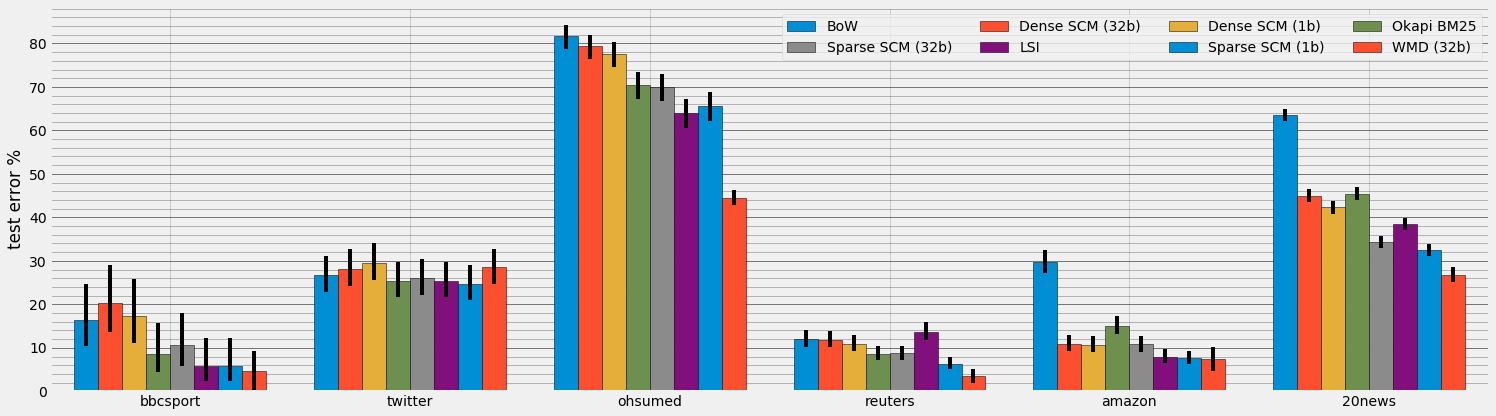

In [12]:
%matplotlib inline

from itertools import chain, cycle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


def flip(items, ncol):
    return chain(*[items[i::ncol] for i in range(ncol)])

num_bars = len(configurations)
num_datasets = len(dataset_names)
bar_width = 1.0 / (num_bars + 2)
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))
bar_xs = [
    np.arange(num_datasets) + bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]
hatches = (' ', '///', '...', 'xxx', '\\\\\\', '**', 'xx', '.', '*', 'o', 'O')

# rcParams['font.size'] = 9
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']
plt.style.use('fivethirtyeight')

# fig = plt.figure(figsize=(7, 4))
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    # plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = 4
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol)

plt.xticks(bar_xs[num_bars // 2] - 0.5 * bar_width, dataset_names)
plt.minorticks_on()
plt.ylabel('test error %')
plt.xlim((-0.5 * (num_bars + 2) * bar_width, num_datasets - 1 + 0.5 * (num_bars + 2) * bar_width))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-test_error.pdf')
plt.show()

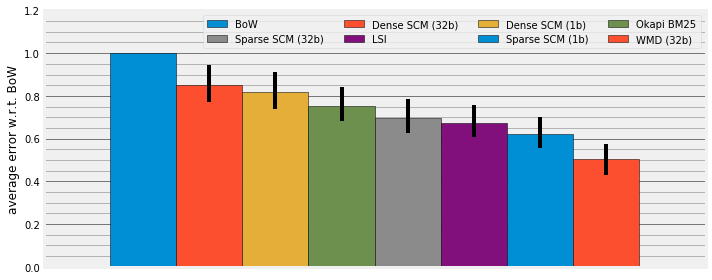

In [13]:
bar_ys = list(map(lambda x: sum(x) / len(x), bar_ys))
bar_yerrs_lower = list(map(lambda x: sum(x) / len(x), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: sum(x) / len(x), bar_yerrs_upper))

baseline_configuration = ('vsm', 'bow', 'inner_product', 32)
baseline_configuration_index = configurations.index(baseline_configuration)
baseline_y = bar_ys[baseline_configuration_index]

bar_ys = list(map(lambda x: (x / baseline_y, ), bar_ys))
bar_yerrs_lower = list(map(lambda x: (x / baseline_y, ), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: (x / baseline_y, ), bar_yerrs_upper))
bar_yerrs_lower[baseline_configuration_index] = (0.0, )
bar_yerrs_upper[baseline_configuration_index] = (0.0, )
bar_xs = [
    bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]

# fig = plt.figure(figsize=(3, 4))
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    # plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = 4
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol)

plt.xticks((), ())
plt.minorticks_on()
plt.ylabel('average error w.r.t. BoW')
plt.xlim((-0.5 * (num_bars + 2) * bar_width, 0.5 * (num_bars + 2) * bar_width))
plt.ylim((0.0, 1.2))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-avg_test_error_ratio.pdf')
plt.show()